In [1]:
# Propagation from AZ/EL observations
# Perturbation:
# N/A
# Maneuver: 
# No

# IOD
# Given from propagation_issX

# Obserbation:
# AZ/EL
# TOD / IERS_2010

# Output:
# TBD

# Remark: Implementation of the Orbdetpy methods Estimation.java

In [2]:
%matplotlib inline

from math import radians, pi, degrees
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import signal

import orekit
vm = orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime
setup_orekit_curdir()

from org.orekit.orbits import KeplerianOrbit, PositionAngle
from org.orekit.propagation.analytical import KeplerianPropagator
from org.orekit.time import AbsoluteDate, TimeScalesFactory, TimeScale
from org.orekit.utils import Constants
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.attitudes import LofOffset
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid
from org.orekit.forces.drag import IsotropicDrag
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.maneuvers import ImpulseManeuver
from org.orekit.frames import FramesFactory, LOFType, EOPHistory
from org.orekit.models.earth.atmosphere import HarrisPriester
from org.orekit.orbits import CircularOrbit, OrbitType, PositionAngle
from org.orekit.propagation import PropagationType, SpacecraftState
from org.orekit.propagation.events import DateDetector, EventEnablingPredicateFilter, PythonEnablingPredicate,\
     PositionAngleDetector, PythonEventDetector, AbstractDetector, EventDetector
from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder, DSSTPropagatorBuilder, \
     ClassicalRungeKuttaIntegratorBuilder, EulerIntegratorBuilder
from org.orekit.propagation.semianalytical.dsst.forces import DSSTAtmosphericDrag, DSSTNewtonianAttraction, DSSTZonal
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions, PVCoordinatesProvider
from orekit.pyhelpers import absolutedate_to_datetime
from org.hipparchus.linear import RealMatrix
from org.hipparchus.linear import QRDecomposer, AbstractRealMatrix
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
from org.orekit.estimation.leastsquares import BatchLSEstimator
from org.orekit.propagation.numerical import NumericalPropagator
from org.orekit.propagation.conversion import AbstractPropagatorBuilder, PropagatorBuilder

from org.orekit.estimation.measurements import AngularAzEl
from org.orekit.estimation.measurements import ObservableSatellite
from org.orekit.estimation.measurements import GroundStation
from org.orekit.estimation.sequential import KalmanEstimatorBuilder
from org.orekit.estimation.sequential import KalmanEstimator
from org.orekit.estimation.sequential import KalmanEstimation,AbstractCovarianceMatrixProvider
from org.orekit.estimation.measurements import *
from org.orekit.estimation.iod import IodGooding, IodLaplace

from orekit.pyhelpers import absolutedate_to_datetime, datetime_to_absolutedate, JArray_double2D
from collections import namedtuple
from org.orekit.time import Month
from orekit import JArray

from org.orekit.estimation.sequential import KalmanEstimator, KalmanEstimatorBuilder, CovarianceMatrixProvider, ConstantProcessNoise
from org.orekit.orbits import Orbit
from org.hipparchus.linear import MatrixUtils

from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngle

from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel

from org.orekit.utils import ParameterDriver

from org.hipparchus.linear import Array2DRowRealMatrix  
from org.orekit.estimation.sequential import KalmanEstimatorBuilder, KalmanEstimation
from org.orekit.orbits import CartesianOrbit, Orbit
from org.orekit.utils import TimeStampedPVCoordinates

In [3]:
def initCov(initialCov, initData, matSize):
    for i in range(0,matSize):
        initialCov.setEntry(i, i, 1.0);
        for j in range(0,i):
            initialCov.setEntry(i, j, initData[j]);
            initialCov.setEntry(j, i, initData[j]);
            #print(initData[j])
    return initialCov

def getAzElDate(datetime, ref):
    year = int(datetime[1:5])
    month = int(datetime[6:8])
    day = int(datetime[9:11])
    hour = int(datetime[12:14])
    minute = int(datetime[15:17])
    second = int(datetime[18:20])
    return AbsoluteDate(year, Month.getMonth(month), day, hour, minute, 0.0, ref)

In [4]:
# ADS Inputs
a = 6500000.0  
e = 0.3
i = radians(98.0)     
omega = radians(0.2)   # perigee argument
raan = radians(90.0)  # right ascension of ascending node
lv = radians(0.0)#0.1)    # True anomaly


#mass = 625.0
utc = TimeScalesFactory.getUTC()
initialDate = AbsoluteDate(2020, 1, 1, 0, 0, 00.000, utc)

## Inertial frame where the satellite is defined
inertialFrame =  FramesFactory.getTOD(IERSConventions.IERS_2010, False)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         inertialFrame)

## Orbit construction as Keplerian
initialOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngle.TRUE,
                              inertialFrame, initialDate, Constants.WGS84_EARTH_MU)

# Orbit propagator parameters
prop_min_step = 10.0 # s
prop_max_step = 24*3600.0 # s
prop_position_error = 1000.0 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_convergence_thres = 1e-3
estimator_max_iterations = 25
estimator_max_evaluations = 35


In [5]:
# 182

integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)
kepPropagatorBuilder = NumericalPropagatorBuilder(initialOrbit,
                                                   integratorBuilder,
                                                   PositionAngle.MEAN,
                                                   estimator_position_scale)

# Earth gravity field with degree 20 and order 20
gravityProvider = GravityFieldFactory.getConstantNormalizedProvider(20,20)
gravityAttractionModel = HolmesFeatherstoneAttractionModel(inertialFrame, gravityProvider)
kepPropagatorBuilder.addForceModel(gravityAttractionModel)


In [6]:

if 1:
    plst = kepPropagatorBuilder.getPropagationParametersDrivers()

    dragCoefficient = ParameterDriver('Cd', 2.0, 1.0, 1.0, 3.0)
    dragCoefficient.setSelected(True)
    plst.add(dragCoefficient)

    rpCoeffReflection = ParameterDriver('Cr', 1.5, 1.0, 1.0, 2.0)
    rpCoeffReflection.setSelected(True)
    plst.add(rpCoeffReflection)

    estmDMCAcceleration = ParameterDriver('DMC', 0.1, 1.0, -1.0e-2, -1.0e-2)
    estmDMCAcceleration.setSelected(True)
    plst.add(estmDMCAcceleration)



In [7]:
# Creation of Noise matrix
def initCovLower2(initialCov, initData, matSize):
    for i in range(0,matSize):
        initialCov.setEntry(i, i, initData[i]);
        for j in range(0,i):
            initialCov.setEntry(i, j, initData[j]);
            initialCov.setEntry(j, i, initData[j]);
            #print(initData[j])
    return initialCov

def initCov2(initialCov, initData, matSize):
    for i in range(0,matSize):
        initialCov.setEntry(i, i, initData[i]);
        for j in range(0,matSize):
            initialCov.setEntry(i, j, initData[j]);
            initialCov.setEntry(j, i, initData[j]);
            #print(initData[j])
    return initialCov
def initDiag2(initialCov, initData, matSize):
    for i in range(0,matSize):
        initialCov.setEntry(i, i, initData[i]);
    return initialCov

matSize = 9
Q = MatrixUtils.createRealDiagonalMatrix([10000.0, 0.2, 0.3, 0.3,0.3,0.3, 10.0, 10.0, 10.0])
Q = MatrixUtils.createRealDiagonalMatrix([10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0])
Q = MatrixUtils.createRealDiagonalMatrix([1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 10.0, 10.0, 10.0])
Q = MatrixUtils.createRealDiagonalMatrix([1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12])
# Good results
Q = MatrixUtils.createRealDiagonalMatrix([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1])

initialCov = Array2DRowRealMatrix(matSize,matSize)
initData = [25e6, 25e6, 25e6, 1e2, 1e2, 1e2, 1.00, 0.25, 1e-1, 1e-1, 1e-1]
initData = [25e6, 0.5, 0.5, 0.5, 0.5, 0.5, 1.00, 0.25, 1e-1, 1e-1,1e-1]
# Good results
initData = [1e10, 1e-0, 1e-0, 1e-0, 1e-0, 1e-0, 1e-0, 1e-0, 1e-0, 1e-0 ,1e-0]
#initialCov = MatrixUtils.createRealDiagonalMatrix([3.739752914*1*1, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001,3.0, 3.0, 3.0])
#initData = [3.739752914*1*1, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001,3.0, 3.0, 3.0]

initialCov = initCovLower2(initialCov, initData, matSize)

 
print(initialCov.getRowDimension())

# Build the Kalman filter
processNoise = ConstantProcessNoise(initialCov, Q)

kalman = KalmanEstimatorBuilder().addPropagationConfiguration(kepPropagatorBuilder, processNoise) # KalmanEstimatorBuilder

filter = kalman.build() # KalmanEstimator


9


In [8]:
initialCov

<Array2DRowRealMatrix: Array2DRowRealMatrix{{10000000000.0,10000000000.0,10000000000.0,10000000000.0,10000000000.0,10000000000.0,10000000000.0,10000000000.0,10000000000.0},{10000000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0},{10000000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0},{10000000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0},{10000000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0},{10000000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0},{10000000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0},{10000000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0},{10000000000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0}}>

In [9]:
# Build ObservedMeasurement
#Open and collect data from csv
file = pd.read_csv("export_visible_NoPert.csv")
az = file['azimuth']
el = file['elevation']
datetime = file['pv']
idx = datetime[0].find(',')

errDeg = 0.001 #10*0.000277778 #1 arcsec
azBaseWeight = 1.0
elBaseWeight = 1.0

frame = FramesFactory.getTOD(IERSConventions.IERS_2010, False)

earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         frame)
longitude = radians(21.038)
latitude  = radians(67.8790708)
altitude  = 527.0
station = GeodeticPoint(latitude, longitude, altitude)
stationFrame = TopocentricFrame(earth, station, "Kiruna")

ObsSat= ObservableSatellite(0) # From R5
EKF_a = []  
EKF_e = [] 
EKF_i = []     
EKF_omega = []  
EKF_raan = []  
EKF_lv = [] 
newCovMatrix = []

Elt1 = []
Elt2 = []
Elt3 = []
Elt4 = []
Elt5 = []
Elt6 = []

Kk = []

iFail = 0
FAIL_MAX = 50

#for j in range(0,len(az),3):
for j in range(0,len(az)):
    date = getAzElDate(datetime[j], utc)
    if j!=0 and j%50000==0:
        print('iteration ',j)
        print(EKF_a[-1], EKF_e[-1], EKF_i[-1], EKF_omega[-1], EKF_raan[-1], EKF_lv[-1])
        print(date)
        initialOrbit = KeplerianOrbit(EKF_a[-1], EKF_e[-1], EKF_i[-1], EKF_omega[-1], EKF_raan[-1], EKF_lv[-1],
                              PositionAngle.TRUE,
                              inertialFrame, date, Constants.WGS84_EARTH_MU)
        kepPropagatorBuilder = NumericalPropagatorBuilder(initialOrbit,
                                                   integratorBuilder,
                                                   PositionAngle.MEAN,
                                                   estimator_position_scale)
        
        kepPropagatorBuilder.addForceModel(gravityAttractionModel)
        plst = kepPropagatorBuilder.getPropagationParametersDrivers()

        dragCoefficient = ParameterDriver('Cd', 2.0, 1.0, 1.0, 3.0)
        dragCoefficient.setSelected(True)
        plst.add(dragCoefficient)

        rpCoeffReflection = ParameterDriver('Cr', 1.5, 1.0, 1.0, 2.0)
        rpCoeffReflection.setSelected(True)
        plst.add(rpCoeffReflection)

        estmDMCAcceleration = ParameterDriver('DMC', 0.1, 1.0, -1.0e-2, -1.0e-2)
        estmDMCAcceleration.setSelected(True)
        plst.add(estmDMCAcceleration)   
        #Q = MatrixUtils.createRealDiagonalMatrix([10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0])
        processNoise = ConstantProcessNoise(newCovMatrix[-1], Q)
        
        kalman = KalmanEstimatorBuilder().addPropagationConfiguration(kepPropagatorBuilder, processNoise) # KalmanEstimatorBuilder
        filter = kalman.build()
        
    
    orekitAzEl = AngularAzEl(GroundStation(stationFrame),
                    date,
					JArray('double')([radians(az[j]),radians(el[j])]),
                    JArray('double')([radians(errDeg),radians(errDeg)]),
                    JArray('double')([azBaseWeight,elBaseWeight]),
                    ObsSat)
    try:
        filter.estimationStep(orekitAzEl)
        
        newEstimatedState = filter.getPhysicalEstimatedState()

        EKF_a.append(newEstimatedState.getEntry(0))
        EKF_e.append(newEstimatedState.getEntry(1))
        EKF_i.append(newEstimatedState.getEntry(2))
        EKF_omega.append(newEstimatedState.getEntry(3))
        EKF_raan.append(newEstimatedState.getEntry(4))
        EKF_lv.append(newEstimatedState.getEntry(5))
        
        newCovMatrix.append(filter.getPhysicalEstimatedCovarianceMatrix())
           
        Elt1.append(newCovMatrix[-1].getEntry(1, 1))
        Elt2.append(newCovMatrix[-1].getEntry(2, 2))
        Elt3.append(newCovMatrix[-1].getEntry(3, 3))
        Elt4.append(newCovMatrix[-1].getEntry(4, 4))
        Elt5.append(newCovMatrix[-1].getEntry(5, 5))
        Elt6.append(newCovMatrix[-1].getEntry(6, 6))
        
        #Kk.append(filter.getPhysicalKalmanGain())

    except:
        print('Problem iteration: ', j)
        iFail += 1
        if iFail >= FAIL_MAX:
            break        
        #print(ValueError)
    #a = filter.getCurrentDate()
    #print(a,newEstimatedState)

#print(orekitAzEl.getDate())
a = filter.getCurrentDate()
print(a,newEstimatedState)
newCovMatrix[-1]

Problem iteration:  0
Problem iteration:  16
Problem iteration:  17
Problem iteration:  18
Problem iteration:  19
Problem iteration:  20
Problem iteration:  21
Problem iteration:  22
Problem iteration:  23
Problem iteration:  24
Problem iteration:  25
Problem iteration:  26
Problem iteration:  27
Problem iteration:  28
Problem iteration:  29
Problem iteration:  30
Problem iteration:  31
Problem iteration:  32
Problem iteration:  33
Problem iteration:  34
Problem iteration:  35
Problem iteration:  36
Problem iteration:  37
Problem iteration:  38
Problem iteration:  39
Problem iteration:  40
Problem iteration:  41
Problem iteration:  42
Problem iteration:  43
Problem iteration:  44
Problem iteration:  45
Problem iteration:  46
Problem iteration:  47
Problem iteration:  48
Problem iteration:  49
Problem iteration:  50
Problem iteration:  51
Problem iteration:  52
Problem iteration:  53
Problem iteration:  54
Problem iteration:  55
Problem iteration:  56
Problem iteration:  57
Problem iter

<RealMatrix: Array2DRowRealMatrix{{576318794365.2507,-54705.8219627732,23311.7162288758,46333.7762681514,47512.4595206372,-510978.3155872748,53408.0198470758,53408.0198470758,53408.0198470758},{-54705.8219625364,1.0571869384,0.2329322333,-0.0435623453,0.0023279494,0.0970592301,-0.0039509815,-0.0039509815,-0.0039509815},{23311.7162289547,0.2329322333,0.0718536759,-0.0740820178,-0.1255965818,-0.023267099,0.0025158308,0.0025158308,0.0025158308},{46333.7762679246,-0.0435623453,-0.0740820178,0.2645888801,0.4808264319,-0.1344951377,0.0032863064,0.0032863064,0.0032863064},{47512.4595204125,0.0023279494,-0.1255965818,0.4808264319,0.9131087152,0.0033246789,0.003465109,0.003465109,0.003465109},{-510978.3155859839,0.0970592301,-0.023267099,-0.1344951377,0.0033246789,1.9571107233,-0.0412397788,-0.0412397788,-0.0412397788},{53408.019845488,-0.0039509815,0.0025158308,0.0032863064,0.003465109,-0.0412397788,1.6254802009,0.0254802009,0.0254802009},{53408.019845488,-0.0039509815,0.0025158308,0.003286306

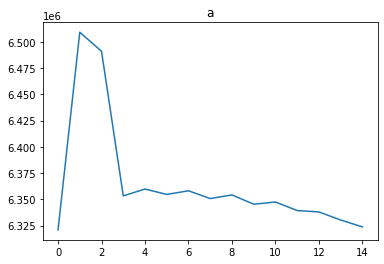

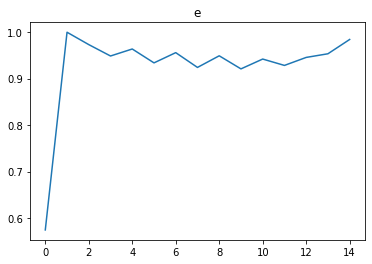

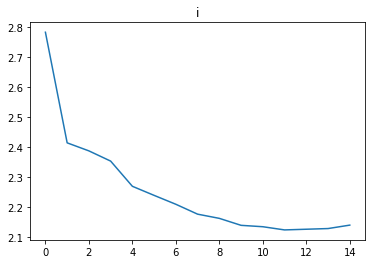

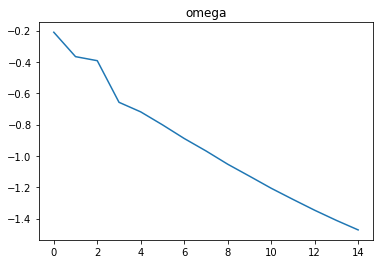

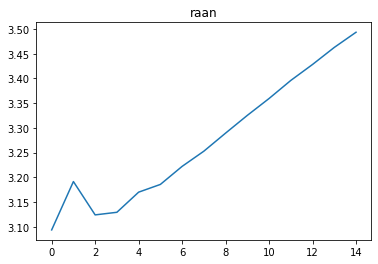

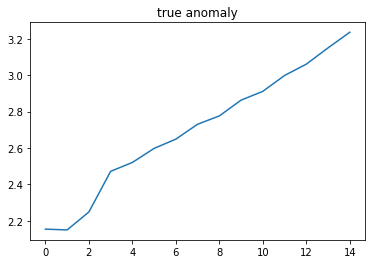

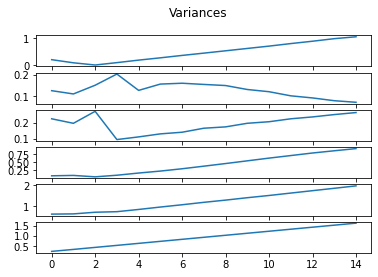

In [10]:
import matplotlib.pyplot as plt
plt.plot(EKF_a)
plt.title('a')
plt.show()
plt.plot(EKF_e)
plt.title('e')
plt.show()
plt.plot(EKF_i)
plt.title('i')
plt.show()
plt.plot(EKF_omega)
plt.title('omega')
plt.show()
plt.plot(EKF_raan)
plt.title('raan')
plt.show()
plt.plot(EKF_lv)
plt.title('true anomaly')
plt.show()

fig, axs = plt.subplots(6)
fig.suptitle('Variances')
axs[0].plot(Elt1[:])
axs[1].plot(Elt2[:])
axs[2].plot(Elt3[:])
axs[3].plot(Elt4[:])
axs[4].plot(Elt5[:])
axs[5].plot(Elt6[:])

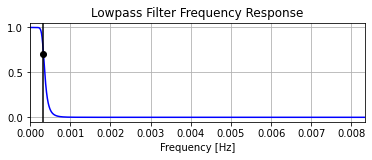

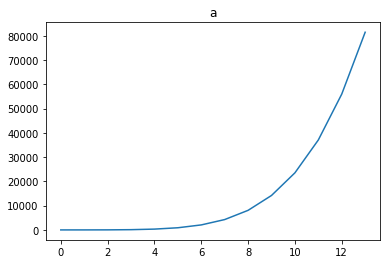

16278.575538317791


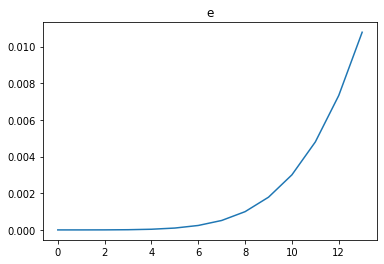

0.0021142981916293857


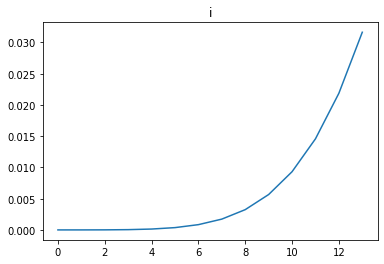

0.006386914736108872


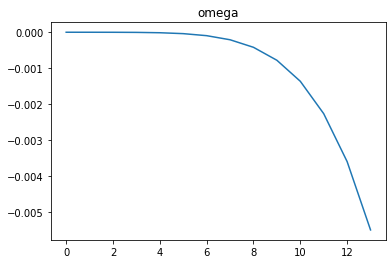

-0.0010212799029911716


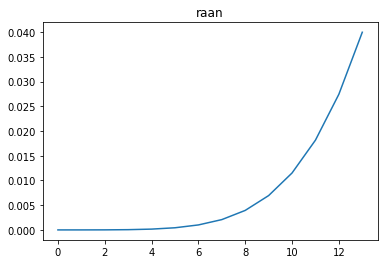

0.007981436122790113


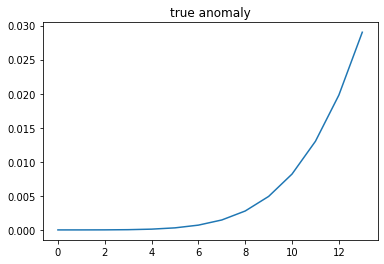

0.005739702044128363


In [11]:
data = EKF_a


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 1/60      # sample rate, Hz
cutoff = 1/60/50  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = signal.freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 60*24*3*40        # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
# data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

EKF_aF = butter_lowpass_filter(EKF_a, cutoff, fs, order)
EKF_eF = butter_lowpass_filter(EKF_e, cutoff, fs, order)
EKF_iF = butter_lowpass_filter(EKF_i, cutoff, fs, order)
EKF_omegaF = butter_lowpass_filter(EKF_omega, cutoff, fs, order)
EKF_raanF = butter_lowpass_filter(EKF_raan, cutoff, fs, order)
EKF_lvF = butter_lowpass_filter(EKF_lv, cutoff, fs, order)

#plt.subplot(2, 1, 2)
#plt.plot(t, data, 'b-', label='data')
#plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
#plt.xlabel('Time [sec]')
#plt.grid()
#plt.legend()

#plt.subplots_adjust(hspace=0.35)
#plt.show()
x = 0
limit = False
from statistics import mean
plt.plot(EKF_aF[x:-1])
plt.title('a')
if limit:
    plt.ylim([6900000,7050000])
plt.show()
print(mean(EKF_aF[-60:-1]))

plt.plot(EKF_eF[x:-1])
plt.title('e')
if limit:
    plt.ylim([0.19,0.21])
plt.show()
print(mean(EKF_eF[-60:-1]))

plt.plot(EKF_iF[x:-1])
plt.title('i')
plt.show()
print(mean(EKF_iF[-60:-1]))

plt.plot(EKF_omegaF[x:-1])
plt.title('omega')
plt.show()
print(mean(EKF_omegaF[-60:-1]))

plt.plot(EKF_raanF[x:-1])
plt.title('raan')
plt.show()
print(mean(EKF_raanF[-60:-1]))

plt.plot(EKF_lvF[x:-1])
plt.title('true anomaly')
plt.show()
print(mean(EKF_lvF[-60:-1]))

In [12]:
from org.orekit.estimation.sequential import KalmanObserver
kal = KalmanEstimation
kal_obs = KalmanObserver
kal_obs.evaluationPerformed(kalman)

TypeError: descriptor 'evaluationPerformed' for 'KalmanObserver' objects doesn't apply to a 'KalmanEstimatorBuilder' object

In [ ]:
from org.orekit.estimation.sequential import KalmanModel

KalmanModel(kepPropagatorBuilder, newCovMatrix[-1], newEstimatedState,Q)


In [ ]:
from org.orekit.estimation.sequential import DSSTKalmanModel
from org.orekit.propagation.conversion import IntegratedPropagatorBuilder

kepPropagatorBuilder.buildKalmanModel(kepPropagatorBuilder, \
                                      ConstantProcessNoise(initialCov, Q), \
                                      filter.getEstimatedMeasurementsParameters(), \
                                      ConstantProcessNoise(initialCov, Q))

In [ ]:
newCovMatrix[-1]

In [ ]:

initialCov = Array2DRowRealMatrix(matSize,matSize)

